_just_ inference with all parameters from noisy simulation

In [1]:
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit import *
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit.opflow import CircuitSampler


from qiskit.ignis.mitigation.measurement import CompleteMeasFitter # you will need to pip install qiskit-ignis
from qiskit.ignis.mitigation.measurement import complete_meas_cal

from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

In [2]:
anti = -1
L = 5
num_trash = 2

name = "ibmq_antiferro-1D-load_bogota-optimize-20points" # 01.06.2021 experiment
filename = "data/noisy_VQE_maxiter-500_Ising_L5_anti_-1_20" #"data/noisy_VQE_maxiter-100_Ising_L5_anti_-1_20_recycle"
print("filename: ", filename, "notebook name: ", name)

# where to get the simulated thetas values from? needs to contain a thetas_mitigated array
filename_simulated_thetas = 'data/ibmq_antiferro-1D-load_bogota-optimize_thetas-loss-cost_run2.npz'

filename:  data/noisy_VQE_maxiter-500_Ising_L5_anti_-1_20 notebook name:  ibmq_antiferro-1D-load_bogota-optimize-20points


In [3]:
load = True
recompute = False # whether or not to recompute Magnetization, makes sense on device

## 1D

In [4]:
# this is noisy simulation data
L = 5
num_trash = 2
anti = -1

VQE_params = np.load(filename + ".npz", allow_pickle=True)
pick = np.arange(0,len(VQE_params['gx_list']))
gx_list = VQE_params['gx_list'][pick]
gz_list = VQE_params['gz_list'][pick]
opt_params = VQE_params['opt_params'][pick]
Qmags = VQE_params["Qmag"][pick]
Qen = VQE_params["Qen"][pick]
Sen = VQE_params["Sen"][pick]
Smags = VQE_params["Smag"][pick]

gx_vals = np.unique(gx_list)
gz_vals = np.unique(gz_list)

In [5]:
# these are the results from using precalculated VQE values from noisy simulation on the real device (ibmq_bogota)
if load:
    temp = np.load("data/" + name + "executed_mags-Es.npz",allow_pickle=True)
    Qmags_executed = temp["Qmags"]

In [6]:
# these are values actually obtained with VQE on ibmq_rome
VQE_params = np.load("data/rome_VQE_maxiter-30_Ising_L5_anti_-1_20_recycle.npz", allow_pickle=True)
print(VQE_params.files)
pick = np.arange(0,len(VQE_params['gx_list']))
gx_list2 = VQE_params['gx_list'][pick]
gz_list2 = VQE_params['gz_list'][pick]
opt_params2 = VQE_params['opt_params'][pick]
Qmags2 = VQE_params["Qmag"][pick]
Qen2 = VQE_params["Qen"][pick]
Sen2 = VQE_params["Sen"][pick]
Smags2 = VQE_params["Smag"][pick]

gx_vals2 = np.unique(gx_list2)
gz_vals2 = np.unique(gz_list2)

['gx_list', 'gz_list', 'opt_params', 'Qmag', 'Qen', 'Sen', 'Smag', 'ansatz_config']


/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


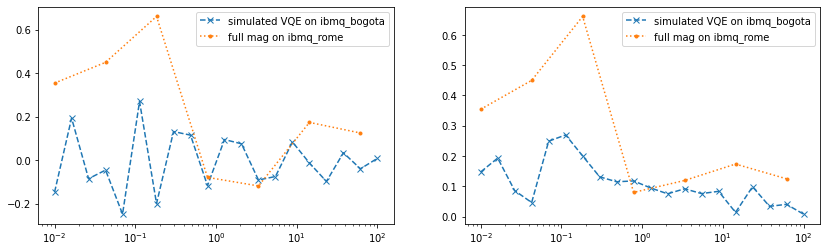

In [7]:
fig, axs = plt.subplots(ncols=2,figsize=(14,4))
ax=axs[0]
ax.plot(gx_list, Qmags_executed,"x--", label="simulated VQE on ibmq_bogota")
ax.plot(gx_list2, Qmags2,".:", label = "full mag on ibmq_rome")
ax.set_xscale("log")
ax.legend()

ax=axs[1]
ax.plot(gx_list, abs(Qmags_executed),"x--", label="simulated VQE on ibmq_bogota")
ax.plot(gx_list2, abs(Qmags2),".:", label = "full mag on ibmq_rome")
ax.set_xscale("log")
ax.legend()

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, '$\\mid M \\mid$')

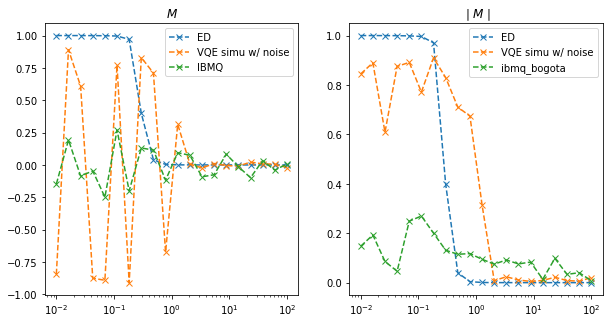

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(gx_list, Smags,"x--", label="ED")
ax.plot(gx_list, Qmags,"x--", label="VQE simu w/ noise")
ax.set_xscale("log")
if recompute or load:
    ax.plot(gx_list, Qmags_executed,"x--", label="IBMQ")
ax.legend()
ax.set_title("$M$")

ax = axs[1]
ax.plot(gx_list, Smags,"x--", label="ED")
ax.plot(gx_list, abs(Qmags),"x--", label="VQE simu w/ noise")
ax.set_xscale("log")
if recompute or load:
    ax.plot(gx_list, abs(Qmags_executed),"x--", label="ibmq_bogota")
ax.legend()
ax.set_title("$\\mid M \\mid$")

In [9]:
##############################################################################
### II - Training  ###########################################################
##############################################################################

In [10]:
cal_matrix = np.array([[0.982, 0.036, 0.032, 0.003],
 [0.011, 0.959, 0.,    0.036],
 [0.007, 0.001, 0.962, 0.023],
 [0.,    0.004, 0.006, 0.938]]) # this was the one from the experiment

## Error Mitigation
Should we use error mitigation or not?

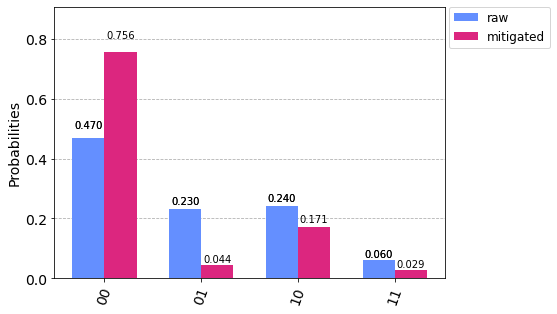

In [11]:
from qiskit.tools.visualization import *
temp = np.load("data/" + 'ibmq_antiferro-1D-load_simu' + "raw-vs-mitigated-counts.npz",allow_pickle=True)
plot_histogram([temp["raw_counts"].item(), temp["mitigated_counts"].item()], legend=['raw', 'mitigated'])

In [12]:
counts0 = temp["raw_counts"].item()
counts1 = temp["mitigated_counts"].item()

In [13]:
sortkeys = list(sorted([_ for _ in counts0]))

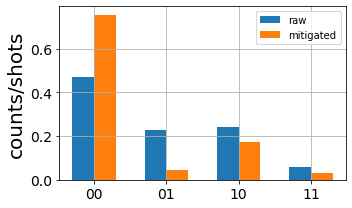

In [14]:
fig, ax = plt.subplots(figsize=(5,3))
plt.grid()
sortkeys = list(sorted([_ for _ in counts0]))
vals = np.array([counts0[_] for _ in sortkeys])
vals = vals/np.sum(vals)
ax.bar(sortkeys,vals, width=-0.3, align="edge", label="raw")

sortkeys = list(sorted([_ for _ in counts1]))
vals = np.array([counts1[_] for _ in sortkeys])
vals = vals/np.sum(vals)
ax.bar(sortkeys,vals, width=0.3, align="edge", label="mitigated")
ax.legend()
plt.tick_params(labelsize=14)
ax.set_ylabel("counts/shots", fontsize=20)
plt.tight_layout()
plt.savefig("plots/counts_mitigated-vs-raw.png")
plt.savefig("plots/counts_mitigated-vs-raw.pdf")

In [15]:
phis = opt_params

In [16]:
# translate to Rikes naming

gxs = gx_list
gzs = gz_list

## Run 1

In [17]:
phys_params= [0]

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


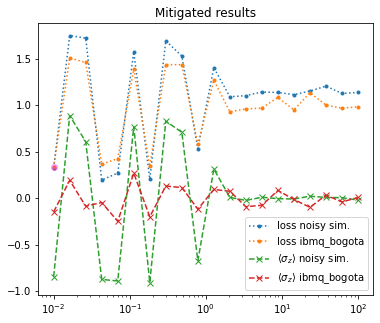

In [18]:
fig, ax = plt.subplots(ncols=1,figsize=(6,5))
ax.set_title("Mitigated results")
cost = np.load("data/" + "ibmq_antiferro-1D-load_simu" + "_thetas-loss-cost_run1.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="loss noisy sim.")

cost = np.load("data/" + name + "_thetas-loss-cost_run1.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="loss ibmq_bogota")

ax.plot(gx_list, Qmags,"x--", label="$\\langle \\sigma_z \\rangle$ noisy sim.")
ax.plot(gx_list, Qmags_executed,"x--", label="$\\langle \\sigma_z \\rangle$ ibmq_bogota")
ax.set_xscale("log")
for p in phys_params:
    ax.plot(gx_list[p],cost[p],"o",alpha=0.3,color="magenta")
ax.legend()

In [19]:
phys_params = [-1]

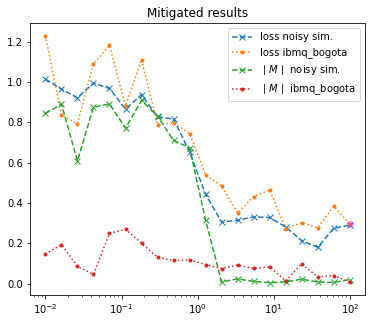

In [20]:
fig, ax = plt.subplots(ncols=1,figsize=(6,5))
ax.set_title("Mitigated results")
cost = np.load("data/" + "ibmq_antiferro-1D-load_simu" + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,"x--", label="loss noisy sim.")

cost = np.load("data/" + name + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="loss ibmq_bogota")

ax.plot(gx_list, abs(Qmags),"x--", label="$\\mid M \\mid$ noisy sim.")
ax.plot(gx_list, abs(Qmags_executed),".:", label="$\\mid M \\mid$ ibmq_bogota")
ax.set_xscale("log")
for p in phys_params:
    ax.plot(gx_list[p],cost[p],"o",alpha=0.3,color="magenta")
ax.legend()

# Main plot

In [21]:
name

'ibmq_antiferro-1D-load_bogota-optimize-20points'

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


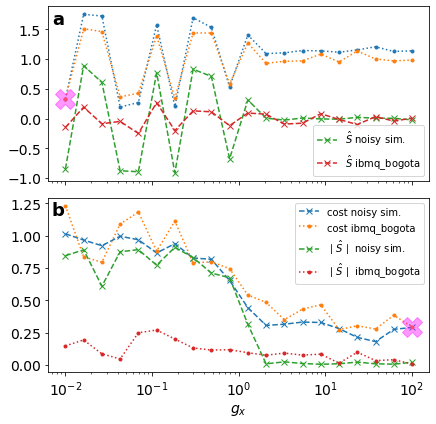

In [29]:
fig, axs = plt.subplots(nrows=2,figsize=(6,6),sharex=True,gridspec_kw={'height_ratios': [2, 2]})
ax = axs[0]
cost = np.load("data/" + "ibmq_antiferro-1D-load_simu" + "_thetas-loss-cost_run1.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:")#, label="loss noisy sim.")

cost = np.load("data/" + name + "_thetas-loss-cost_run1.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:")#, label="loss ibmq_bogota")

ax.plot(gx_list, Qmags,"x--", label="$\hat{S}$ noisy sim.")
ax.plot(gx_list, Qmags_executed,"x--", label="$\hat{S}$ ibmq_bogota")
ax.set_xscale("log")
ax.plot(gx_list[0],cost[0], "X",markersize=20,alpha=0.4,color="magenta")

ax = axs[1]
cost = np.load("data/" + "ibmq_antiferro-1D-load_simu" + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,"x--", label="cost noisy sim.")

cost = np.load("data/" + name + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="cost ibmq_bogota")

ax.plot(gx_list, abs(Qmags),"x--", label="$\\mid \hat{S} \\mid$ noisy sim.")
ax.plot(gx_list, abs(Qmags_executed),".:", label="$\\mid \hat{S} \\mid$ ibmq_bogota")
ax.set_xscale("log")
ax.plot(gx_list[-1],cost[-1],"X",markersize=20,alpha=0.4,color="magenta")
for ax in axs:
    ax.legend()
    ax.tick_params(labelsize=14)
axs[-1].set_xlabel("$g_x$", fontsize=14)

plt.tight_layout()

axs[0].text(0.01,0.9,"a", fontweight="bold", size=18, transform = axs[0].transAxes)
axs[1].text(0.01,0.9,"b", fontweight="bold", size=18, transform = axs[1].transAxes)
plt.savefig("plots/" + name + "_mainplot.png", bbox_inches='tight')
plt.savefig("plots/" + name + "_mainplot.pdf", bbox_inches='tight')

for presentation

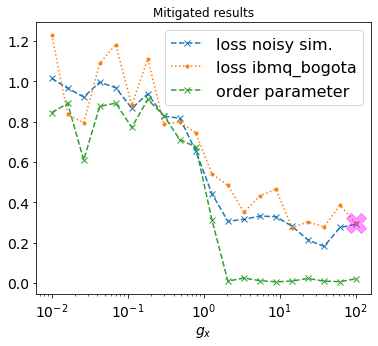

In [99]:
fig, ax = plt.subplots(ncols=1,figsize=(6,5))
ax.set_title("Mitigated results")
cost = np.load("data/" + "ibmq_antiferro-1D-load_simu" + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,"x--", label="loss noisy sim.")

cost = np.load("data/" + name + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="loss ibmq_bogota")

ax.plot(gx_list, abs(Qmags),"x--", label="order parameter")
#ax.plot(gx_list, abs(Qmags_executed),".:", label="$\\mid M \\mid$ ibmq_bogota")
ax.set_xscale("log")
ax.plot(gx_list[-1],cost[-1], "X",markersize=20,alpha=0.4,color="magenta")
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlabel("$g_x$", fontsize=14)
plt.savefig("plots/IBMQ_presentation.png", dpi=400, bbox_inches='tight')

## 2D

In [101]:
cost = np.load("data/ibmq_antiferro-2D_load-AD_10x10_noisy-rome-simu_thetas-loss-cost_run1.npy",allow_pickle=True)
qmag = np.load("data/noisy_rome_simu_VQE_maxiter-500_Ising_L5_anti_-1_10x10.npz", allow_pickle=True)["Qmag"].reshape(10,10)
x,y = np.logspace(-2,2,10), np.logspace(-2,2,10)
x,y = np.meshgrid(x,y)

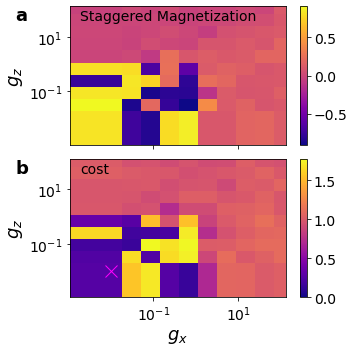

In [105]:
fig,axs = plt.subplots(ncols=1, nrows=2,figsize=(5,5),sharex=True, sharey=True, squeeze=False)
cmap = plt.get_cmap("plasma") #'viridis'
cbar_labelsize = 14
cbar = np.zeros((2,2), dtype="object")

ax = axs[0,0]
im = ax.pcolormesh(x,y,qmag, cmap=cmap, shading="auto",rasterized=True) #,rasterized=True necessary for pdf export
cbar[0,0] = fig.colorbar(im, ax=ax)
cbar[0,0].ax.tick_params(labelsize=cbar_labelsize)

ax = axs[1,0]
im = ax.pcolormesh(x,y,cost,vmin=0, cmap=cmap, shading="auto",rasterized=True)
cbar[1,0] = fig.colorbar(im, ax=ax)
cbar[1,0].ax.tick_params(labelsize=cbar_labelsize)
#ax.plot(vs[47],ds[25],"x", color="magenta")

axs[1,0].plot(1e-2,1e-2,"x", markersize=12, color="magenta")


for ax in axs.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.tick_params(labelsize=14)
axs[1,0].set_xlabel(r"$g_x$",fontsize=18)
axs[0,0].set_ylabel(r"$g_z$",fontsize=18)
axs[1,0].set_ylabel(r"$g_z$",fontsize=18)
plt.tight_layout()

# has to happen after tight_layout()
axs[0,0].text(-0.25,0.9,"a", fontweight="bold", size=18, transform = axs[0,0].transAxes)
axs[1,0].text(-0.25,0.9,"b", fontweight="bold", size=18, transform = axs[1,0].transAxes)
axs[0,0].text(0.05,0.9,"Staggered Magnetization", size=14, transform = axs[0,0].transAxes)
axs[1,0].text(0.05,0.9,"cost", size=14, transform = axs[1,0].transAxes)



plt.savefig("plots/antiferro2D.pdf", bbox_inches='tight')

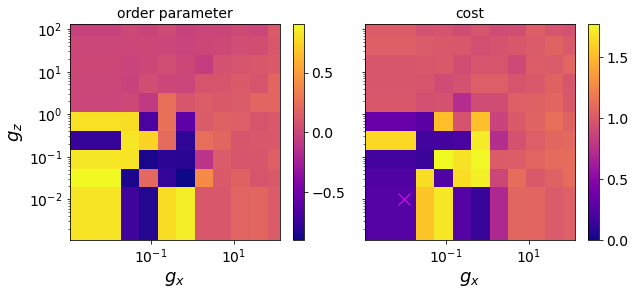

In [107]:
fig,axs = plt.subplots(ncols=2,figsize=(9,4),sharex=True, sharey=True)
cmap = plt.get_cmap("plasma") #'viridis'
cbar_labelsize = 14
cbar = np.zeros((2), dtype="object")

ax = axs[0]
im = ax.pcolormesh(x,y,qmag, cmap=cmap, shading="auto",rasterized=True) #,rasterized=True necessary for pdf export
cbar[0] = fig.colorbar(im, ax=ax)
cbar[0].ax.tick_params(labelsize=cbar_labelsize)

ax = axs[1]
im = ax.pcolormesh(x,y,cost,vmin=0, cmap=cmap, shading="auto",rasterized=True)
cbar[1] = fig.colorbar(im, ax=ax)
cbar[1].ax.tick_params(labelsize=cbar_labelsize)
#ax.plot(vs[47],ds[25],"x", color="magenta")

axs[1].plot(1e-2,1e-2,"x", markersize=12, color="magenta")

for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.tick_params(labelsize=14)
axs[1].set_xlabel(r"$g_x$",fontsize=18)
axs[0].set_xlabel(r"$g_x$",fontsize=18)

axs[0].set_ylabel(r"$g_z$",fontsize=18)
plt.tight_layout()

# has to happen after tight_layout()
#axs[0].text(0.05,0.9,"a Staggered Magnetization", fontweight="bold", size=18, transform = axs[0].transAxes)
#axs[1].text(0.05,0.9,"b cost", fontweight="bold", size=18, transform = axs[1].transAxes)
axs[0].set_title("order parameter", fontsize=14)
axs[1].set_title("cost", fontsize=14)



plt.savefig("plots/antiferro2D_bigger.pdf", bbox_inches='tight')
plt.savefig("plots/antiferro2D_bigger.png", bbox_inches='tight')